# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net
### Preprocessing

#### **Vorbereitung**

In [2]:
# import libraries
import numpy as np
from uuid import uuid4
from random import randint
import os
from pandas import DataFrame
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)
    
import src.preprocessing_v2 as pre
import src.data_loader_v2 as dl
import src.visualization as vis
import src.model_constructor as mc

In [3]:
# boolean values to control the program flow
TESTING: bool = True
DOWNLOAD: bool = False

# setup a single index for control of preprocessing steps
CONTROL_INDEX: int = randint(0,9)

In [4]:
# generate a unique identifier for this run
UUID: str = str(uuid4())

In [5]:
# setup system and check the number of cpu cores and gpus available
mc.system_setup()

Number of CPU cores:		20
Number of GPUs available:	0


#### **Laden der Datensätze**

In [6]:
if DOWNLOAD:
    
    # download full dataset from kaggle
    dl.fetch_kaggle_dataset(dl.DATASET_ADDRESS)

In [7]:
if not TESTING:
    
    # load data from folder and split in training and evaluation data
    data_path = Path().cwd() / "data" / "raw"
    development_data, evaluation_data = dl.load_all_datasets(data_path)
    all_datasets = development_data + evaluation_data

else:

    # program testing set
    test = dl.load_dataset(Path("./data/raw/1D.csv"))

1D.csv successfully loaded.


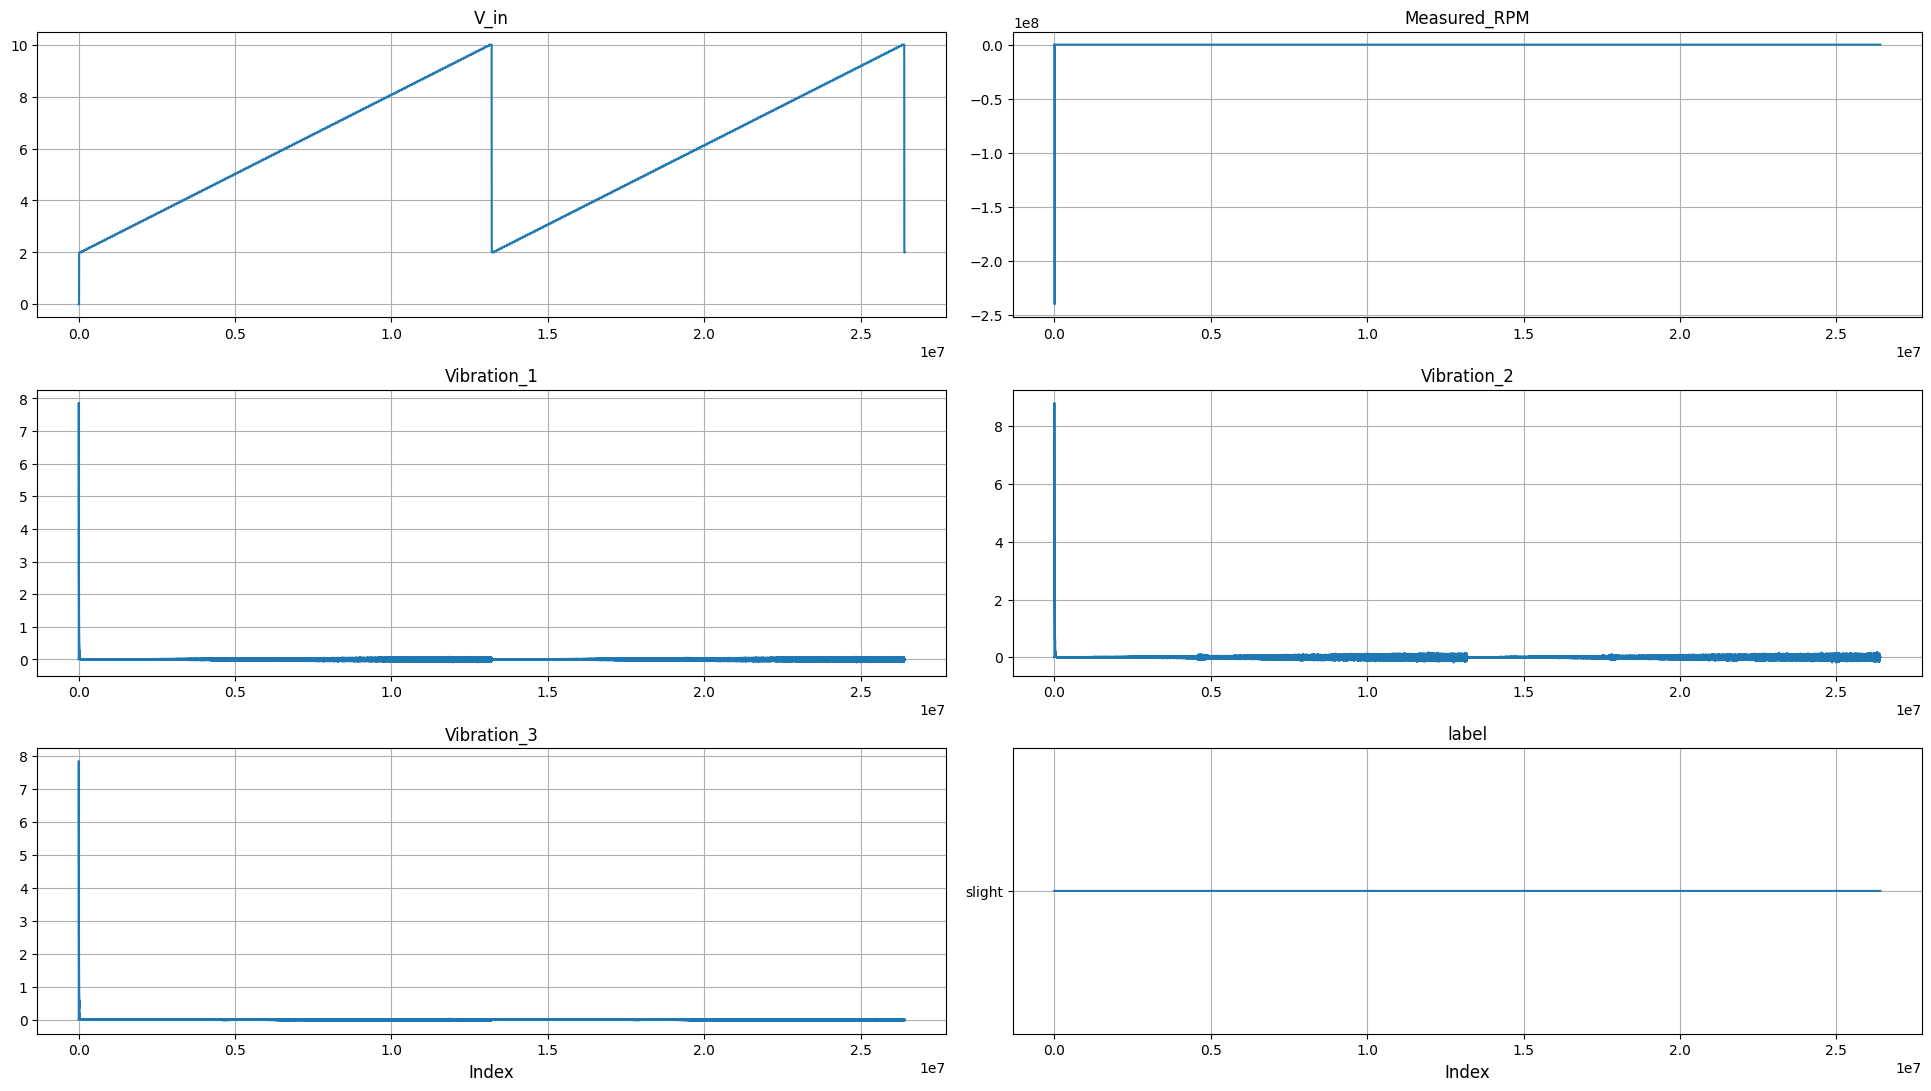

In [8]:
if not TESTING:
    
    # visualize one random dataset for data validation
    vis.plot_columns_as_subplots(all_datasets[CONTROL_INDEX], all_datasets[CONTROL_INDEX].columns)

else:

    # visualize the program testing set
    vis.plot_columns_as_subplots(test, test.columns)

#### **Preprocessing**

##### **Bereinigung der Daten**
Jeder Datensatz beginnt mit negativen Spitzen in den V_in und den Measured_RPM. Tresholding einer der beiden Messreihen entfernt diese Fehler im jeweiligen Datensatz. Durch Anpassung der Indizes beginnt jeder Datensatz mit Index 0.

In [9]:
if not TESTING:

    for dataset in all_datasets:
        pre.apply_threshold(dataset, threshold=0, column="V_in", mode="le", reset_index=True)

else:
    
    pre.apply_threshold(test, threshold=0, column="V_in", mode="le", reset_index=True)

In [ ]:
if not TESTING:

    # visualize one random dataset for data validation
    vis.plot_columns_as_subplots(all_datasets[CONTROL_INDEX],
                                 all_datasets[CONTROL_INDEX].columns)
    
else:

    # visualize the program testing set
    vis.plot_columns_as_subplots(test, test.columns)

##### **Fast Fourier Transformation**
Eine Fast Fourier Transformation (FFT) über führt die Daten eines ausgewählten Sensors vom Zeit- in den Frequenzbereich. Sie verwendet ein Fenster von einer Sekunde bzw. $n=4096$ Messwerten. Mey et al. verwenden in ihrer Arbeit die ersten 2048 Fourier-Koeffizienten. Diese sind der *Zero Frequency Term* bei $0 \times f_s$, die Summe des Signals, und die 2047 positiven Frequenzanteile (*frequency components*). NumPy bietet zur Berechnung der positiven Frequenzanteile die *Real FFT* numpy.rfft(), die in diesem Projekt implementiert ist. Pro Sekunde des ursprünglichen Datensatzes generiert die FFT somit 2048 Frequenzanteile. Aufgrund der Halbierung der Anzahl von Messwerten, speichert ein neues Dataset die Fourier-Koeffizienten. 

$$A_k = \frac{1}{n} \cdot \sum^{n-1}_{m=0} a_m \cdot e^{-2\,\pi\,i\,\frac{m\,k}{n}} \qquad \text{mit} \qquad a_m = e^{2\,\pi\,i\,m\,f\,\Delta t} \quad \text{und} \quad k = 0,~\dots,~n-1$$

Für eine spätere Zuordnung wird mit derselben Fenstergröße der Median der Drehzahlen berechnet. Das Label des ursprünglichen Datensatzes wird in das neue Dataset übertragen.

In [10]:
SENSOR: int = 1

if not TESTING:

    for index, dataset in enumerate(all_datasets):
        # calculate fft frequencies and magnitudes alongside the median rpms
        fft_frequencies, fft_magnitudes = pre.calculate_fft_magnitudes(dataset, column=f"Vibration_{SENSOR}", normalize=False)
        rpms = pre.median(dataset, column="Measured_RPM", stretch=True)
        # empty the dataset and add the new data
        dataset_attributes = dataset.attrs
        dataset = DataFrame({"rpm": rpms[::2],
                             "fft_frequency": fft_frequencies,
                             "fft_magnitude": fft_magnitudes,
                             "label": dataset_attributes["unbalance"]}
                             )
        dataset.attrs = dataset_attributes
        all_datasets[index] = dataset

else:
    
    fft_frequencies, fft_magnitudes = pre.calculate_fft_magnitudes(test, column=f"Vibration_{SENSOR}", normalize=False)
    rpms = pre.median(test, column="Measured_RPM", stretch=True)
    transformed_test = DataFrame({"rpm": rpms[::2],"fft_frequency": fft_frequencies, "fft_magnitude": fft_magnitudes})
    transformed_test.attrs = test.attrs
    transformed_test["label"] = transformed_test.attrs["unbalance"]

In [12]:
if not TESTING:

    # describe one random dataset for data validation
    display(all_datasets[CONTROL_INDEX].describe())

else:
    
    # program testing set
    display(transformed_test.describe())

,rpm,fft_frequency,fft_magnitude
count,1.319526e+07,1.319526e+07,1.319526e+07
mean,1.479953e+03,1.023500e+03,2.579280e-01
std,4.940247e+02,5.912066e+02,1.514152e+00
min,6.131389e+02,0.000000e+00,5.657916e-06
25%,1.053337e+03,5.117500e+02,3.016197e-02
50%,1.475810e+03,1.023500e+03,9.896253e-02
75%,1.907104e+03,1.535250e+03,3.119633e-01
max,3.531306e+03,2.047000e+03,4.142655e+03


##### **Robust Scaling**

Robust Scaling entfernt aus der Messreihe $X$ 

Interquantilabstand (*Inter-Quantile Range*, IRQ) zwischen dem 5%-Quantil $x_{0.05}$ und dem 95%-Quantil $x_{0.95}$.

$$x^*_i = \frac{x_i - \text{median}~{X}}{x_{0.95} - x_{0.05}} \qquad \text{mit} \qquad X=\{x_0,~x_1,~\dots,~x_n-1\}$$

In [14]:
if not TESTING:

    for index, dataset in enumerate(all_datasets):
        all_datasets[index] = pre.scale_robust(dataset, column="fft_magnitude")

else:
    
    transformed_test = pre.scale_robust(transformed_test, column="fft_magnitude")

In [15]:
if not TESTING:

    # describe one random dataset for data validation
    display(all_datasets[CONTROL_INDEX].describe())

else:
    
    # program testing set
    display(transformed_test.describe())

,rpm,fft_frequency,fft_magnitude
count,1.319526e+07,1.319526e+07,1.319526e+07
mean,1.479953e+03,1.023500e+03,1.269369e-01
std,4.940247e+02,5.912066e+02,1.575834e+00
min,6.131389e+02,0.000000e+00,-2.734505e-01
25%,1.053337e+03,5.117500e+02,-1.107504e-01
50%,1.475810e+03,1.023500e+03,0.000000e+00
75%,1.907104e+03,1.535250e+03,2.228726e-01
max,3.531306e+03,2.047000e+03,1.731907e+03


In [ ]:
# Spectrogram erstellen
if not TESTING:
    data_frame=all_datasets[CONTROL_INDEX]
else:
    data_frame=transformed_test

vis.plot_fft_spectrogram(data_frame=data_frame, figsize=(14, 6))

NameError: name 'TESTING' is not defined

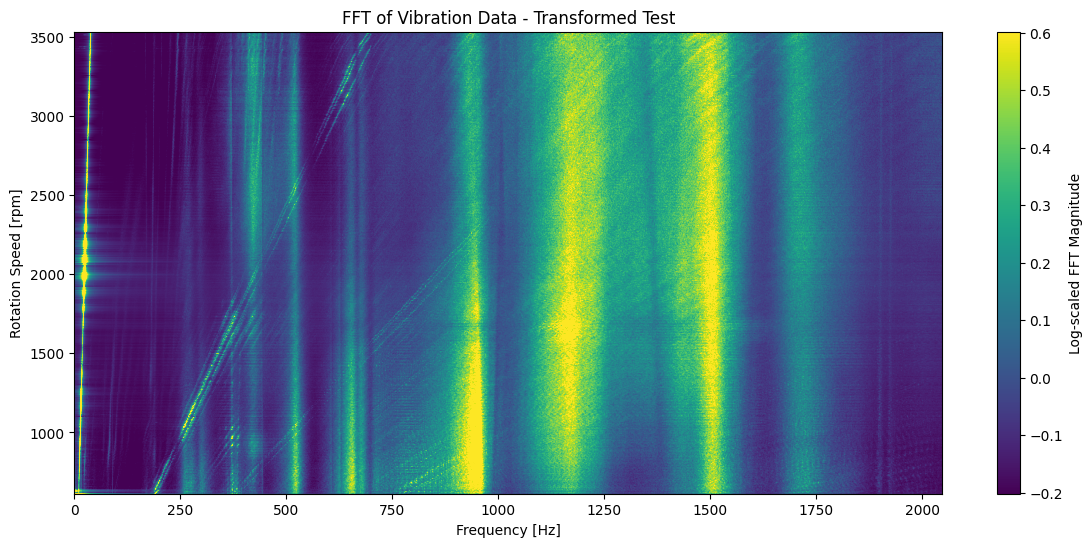

In [ ]:
# Pixelgrafik erstellen

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Pivot-Tabelle erstellen
pivot_data = transformed_test.pivot_table(
    values='fft_magnitude', 
    index='rpm', 
    columns='fft_frequency', 
    fill_value=0
)

# Konvertieren in Matrix
rpm_values = pivot_data.index
freq_values = pivot_data.columns
amplitude_matrix = pivot_data.values

# Logarithmische Skalierung der Amplituden (optional) für bessere Sichtbarkeit
amplitude_matrix = np.log1p(amplitude_matrix)  # Logarithmische Transformation: log(1 + x)

# Grafik erstellen
plt.figure(figsize=(14, 6))  # Breitere Darstellung
plt.imshow(
    amplitude_matrix,
    aspect='auto',  # Automatische Anpassung der Darstellung
    cmap='viridis',  # Farbskala # 'inferno'
    origin='lower',  # Startet bei der unteren linken Ecke
    extent=[freq_values.min(), freq_values.max(), rpm_values.min(), rpm_values.max()],
    vmin=np.percentile(amplitude_matrix, 5),
    vmax=np.percentile(amplitude_matrix, 95)
)

# Achsentitel und Farblegende hinzufügen
plt.colorbar(label='Log-scaled FFT Magnitude')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Rotation Speed [rpm]')
plt.title('FFT of Vibration Data - Transformed Test')

plt.show()


In [ ]:
# WIP validierung für Pixelplot
# Zufällige Stichprobe von 5 Werten aus dem DataFrame
sample = transformed_test.sample(5)  # Wähle 5 zufällige Zeilen aus

# Ausgabe der Stichprobe
print("Zufällige Stichprobe von 5 Werten:")
print(sample)


In [ ]:
# WIP debugging für pixelplot
import src.visualization as vis
print(dir(vis))  # Zeigt alle Attribute und Funktionen im Modul

import importlib
import src.visualization as vis
importlib.reload(vis)


In [ ]:
# WIP aufruf funktion aus vis
importlib.reload(vis)
vis.plot_fft_pixel_graph(
    data_frame=transformed_test,
    freq_col="fft_frequency",
    rpm_col="rpm",
    mag_col="fft_magnitude",
    aspect="auto",  # Breitere Darstellung
    cmap="viridis",  # Farbskala anpassen # "inferno"
    figsize=(14, 6)  # Größe anpassen
)



In [ ]:
# saving the preprocessed data
if not TESTING:

    for dataset in all_datasets:
        dl.save_dataset(dataset, uuid=UUID)

else:
    dl.save_dataset(transformed_test, uuid=UUID)

1D.csv successfully saved.
